# TO-DO

1. Try AMR dataset
2. Train one question after other
3. Look for improvements

# Master Thesis

### Created on Tuesday  June 7th, 2022
### Author: Ganesamanian Kolappan
### Project: Computer Assisted Short Answer Grading with Rubrics using Active Learning


## Importing libraries

##### Importing the libraries to be used in the whole application, for the neatness of the code all the imports are done at the start of the coding.


In [1]:
import numpy as np

import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from modAL.models import ActiveLearner
from modAL.density import information_density

from traitlets.config import Configurable, Config
from traitlets import HasTraits, TraitError, Int, Bool, validate

# Own Imports
from EvaluationMetrics import Metric
from DatasetExtraction import Readdataset
from PreProcessing import PreProcess
from Plot import Plot
from Processing import Processing
from SupervisedLearning import Supervised_learner

## Active learning 
**With custom query method based on intensity calculated as below for the unlabled dataset $X_u$**


$$    I(x)=\frac{1}{|X_u|} \sum_{x'\in X} sim(x, x') $$

$sim(x, x')$ is a cosine similarity function


In [3]:
# Class for active learning wrapper
class Active_learner():
    
    # Class variables
    def __init__(self, X_train, X_test, y_train, y_test, model, percentage):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model         
        self.percent = percentage
#         self.query_method = query_method
    
    # Custom query function
    def intensity_query(self, learner, X):
        cosine_density = information_density(X, 'cosine')
        query_idx = np.argmax(cosine_density)        
        return query_idx, X[query_idx]
    
    # Active learning function
    def learn(self):
        
        '''
            Input:- Model, train and test set, query method, 
                    percentage of data for training AL
            Output:- Accuracy graph and prediction
        '''
        n_queries = int(len(self.X_train)*((100-self.percent)/100))
        
        initial_idx = np.random.choice(range(len(self.X_train)), 
                                       size=(len(self.X_train)-n_queries), 
                                       replace=False)
        
        # seeding, getting initial data for training
#         unique_label = list(set(self.y_train))
#         initial_idx = [np.where(self.y_train == i)[0][0] for i in unique_label]

        # initialising data for training
        X_initial = self.X_train[initial_idx]
        y_initial = self.y_train[initial_idx]

        # generating the pool
        X_pool = np.delete(self.X_train, initial_idx, axis=0)
        y_pool = np.delete(self.y_train, initial_idx, axis=0)
        
#         print(len(X_train), len(X_initial), len(X_pool), len(X_test))

        # initializing the active learner
        learner = ActiveLearner(
            estimator = self.model,
            query_strategy = self.intensity_query,
            X_training = X_initial, y_training = y_initial            
        )
        
        # Calculating initial accuracy with initial data
        accuracy_scores = [learner.score(self.X_test, self.y_test)]
        
        # pool-based sampling
        
#         print("It is calculated minimum", n_queries, "queries are required")
#         print("How you want to proceed?\n 1. Manual\n 2. Automatic")
#         decision_number = np.array([int(input())], dtype=int)
        decision_number = 2
        
        for counter in range(n_queries):
            
#             display.clear_output(wait=True)
            query_idx, query_instance = learner.query(X_pool)
            # Accuracy plot
#             with plt.style.context('seaborn-white'):
#                 plt.figure(figsize=(10, 5))
#                 plt.title('Accuracy of your model')
#                 plt.plot(range(counter+1), accuracy_scores, label="Accuracy")
#                 plt.scatter(range(counter+1), accuracy_scores)
#                 plt.xlabel('Number of queries')
#                 plt.ylabel('Accuracy')
#                 plt.grid()
#                 plt.legend()
#                 display.display(plt.gcf())
#                 plt.close('all')
            
            if decision_number == 1:
                print("What label is this?")
                y_new = np.array([int(input())], dtype=int)
            else:
                y_new = y_pool[query_idx].reshape(1, )
            
            learner.teach(query_instance.reshape(1, -1), y_new)
            
            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)
#             print(len(X_pool), len(y_pool))
            

            accuracy_scores.append(learner.score(self.X_test, self.y_test))
        
#         print("By just labelling ", n_queries, " of total data, accuracy of ", round(accuracy_scores[-1]-accuracy_scores[0], 3), " % is achieved on the unseen data" )
        prediction = learner.predict(self.X_test)
        return prediction

## Function to Run the model

In [ ]:
def runmodel(features, label, model, iterations, al=True):
    
    acc_list = []
    pc_list = []
    rmse_list =[]
    
    for i in range(iterations):

        X_train, X_test, y_train, y_test = train_test_split(features, label)
        
        if al:
            mit = Active_learner(X_train, X_test, y_train, y_test,
                                 model, 95)
        else:
            mit = Supervised_learner(X_train, X_test, y_train, y_test,
                                     model)
            
        mit_predict = mit.learn()  

        mit_metrics = Metric(y_test, mit_predict)
        pc_list.append(mit_metrics.pearsoncorrelation())
        rmse_list.append(mit_metrics.rmse())
        acc_list.append(mit_metrics.accuracy())
        
        if i%10 ==0:
            print("After", i, "iteration")
            print("Average pearson correlation is", np.mean(pc_list))
            print("Average rmse is", np.mean(rmse_list))
            print("Average accuracy is", np.mean(acc_list))


    return pc_list, rmse_list, acc_list

## Data extraction

In [4]:
dataset = Readdataset()
data = dataset.mohlerdataset()
data['answer'].tail()

2268                                                log n
2269                                     ( n(n-1) ) / 2  
2270                                                 2n-1
2271    it takes at most h steps, where h is the heigh...
2272    it depends on the install search tree then fro...
Name: answer, dtype: object

In [5]:
# dataset = Readdataset()
# data = dataset.amrdataset()
# data['answer'].tail()

## Feature extraction

In [6]:
# Object creation
%time process = Processing()
%time pre_process = PreProcess()

CPU times: user 11.3 s, sys: 5.86 s, total: 17.1 s
Wall time: 39.3 s
CPU times: user 1.46 s, sys: 212 ms, total: 1.67 s
Wall time: 1.84 s


In [7]:
# Features holder
sentence_sim_score = np.zeros((len(data), 1))
word_count_score = np.zeros((len(data), 1))
word_count_score_demoted = np.zeros((len(data), 1))
word_embedding_score = np.zeros((len(data), 1))
word_embedding_score2 = np.zeros((len(data), 1))
word_embedding_score_demoted = np.zeros((len(data), 1))
word_embedding_score_demoted2 = np.zeros((len(data), 1))
length_ratio_score = np.zeros((len(data), 1))
length_ratio_score_demoted = np.zeros((len(data), 1))
twograms_score = np.zeros((len(data), 1))
threegrams_score = np.zeros((len(data), 1))
fourgrams_score = np.zeros((len(data), 1))
# elmo_score = np.zeros((len(data), 1))
chunck_score = np.zeros((len(data), 1))

In [8]:
for count in range(len(data['answer'])):
    
    # Sentence embedding
    refans_embed = process.sentence_embedding(data['refanswer'][count])
    answer_embed = process.sentence_embedding(data['answer'][count])
    sentence_sim_score[count,:] = process.cosinesimilarity(refans_embed, answer_embed)
    
#     refans_vec = process.elmo_vectors([data['refanswer'][count]])
#     ans_vec = process.elmo_vectors([data['answer'][count]])    
#     elmo_score[count:] = process.cosinesimilarity(sum(refans_vec), sum(ans_vec))
    
    # Initial preprocessing for refanswer, question and solution
    refans_word_count = process.intialpreprocessing(data['refanswer'][count])
    ans_word_count = process.intialpreprocessing(data['answer'][count])
    qns_word_count = process.intialpreprocessing(data['question'][count])
    
    word_embedding_score[count,:] = process.word_embedding(pre_process.lemmantization(refans_word_count), 
                                                          pre_process.lemmantization(ans_word_count))
    
    word_embedding_score2[count,:] = process.word_embedding2(pre_process.lemmantization(refans_word_count), 
                                                          pre_process.lemmantization(ans_word_count))
    
    word_count_score[count,:] = process.word_count(pre_process.lemmantization(refans_word_count), 
                                                          pre_process.lemmantization(ans_word_count))
    
    twograms_score[count,:] = process.ngrams(pre_process.lemmantization(refans_word_count), 
                                              pre_process.lemmantization(ans_word_count), 2)
    
    threegrams_score[count,:] = process.ngrams(pre_process.lemmantization(refans_word_count), 
                                              pre_process.lemmantization(ans_word_count), 3)
    
    fourgrams_score[count,:] = process.ngrams(pre_process.lemmantization(refans_word_count), 
                                              pre_process.lemmantization(ans_word_count), 4)
    
        
    refans_demoted = pre_process.question_demoting(qns_word_count, refans_word_count)
    ans_demoted = pre_process.question_demoting(qns_word_count, ans_word_count)
    
    refans_lemmma = pre_process.lemmantization(refans_demoted) 
    ans_lemma = pre_process.lemmantization(ans_demoted)
    
    word_count_score_demoted[count,:] = process.word_count(refans_lemmma, ans_lemma)
    word_embedding_score_demoted[count,:] = process.word_embedding(refans_lemmma, ans_lemma)
    word_embedding_score_demoted2[count,:] = process.word_embedding2(refans_lemmma, ans_lemma)
    
    refans_token = pre_process.tokenization(data['refanswer'][count])
    ans_token = pre_process.tokenization(data['answer'][count])
    
    length_ratio_score[count,:] = process.lengthratio(refans_token, ans_token)
    length_ratio_score_demoted[count,:] = process.lengthratio(pre_process.tokenization(refans_lemmma),
                                                             pre_process.tokenization(ans_lemma))
    
    try:
        chunck_score[count,:] = process.word_count(process.chunking(data['refanswer'][count]), 
                                                   process.chunking(data['answer'][count]))
        
    except:
        chunck_score[count,:] = 0
    

    

## Sent+word+chuncking

In [10]:
features = np.hstack((sentence_sim_score, word_embedding_score_demoted, 
                      chunck_score))
label = data['score_avg'].to_numpy().astype(int)

In [11]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.41695379348800893
Average rmse is 1.3499983727126819
Average accuracy is 0.4991212653778559


In [12]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.3922100139592948
Average rmse is 1.3415097860810192
Average accuracy is 0.492091388400703


In [13]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.3699880936518697
Average rmse is 1.3157154728982636
Average accuracy is 0.45166959578207383
After 10 iteration
Average pearson correlation is 0.3697868999441583
Average rmse is 1.3310174409195046
Average accuracy is 0.4673270490493689
After 20 iteration
Average pearson correlation is 0.37956594499847407
Average rmse is 1.3281156418708373
Average accuracy is 0.4679052640388317
After 30 iteration
Average pearson correlation is 0.3862977090348979
Average rmse is 1.3245268205318201
Average accuracy is 0.4699245989001644
After 40 iteration
Average pearson correlation is 0.3904109083536463
Average rmse is 1.3203890336204902
Average accuracy is 0.4710874876762827
After 50 iteration
Average pearson correlation is 0.3857494209295479
Average rmse is 1.325932761711881
Average accuracy is 0.4705193149315965
After 60 iteration
Average pearson correlation is 0.3894127656712075
Average rmse is 1.3207456439905851
Average accuracy is 0.4701950502751448

In [14]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.40187899393801046
Average rmse is 1.3616644420429276
Average accuracy is 0.46045694200351495
After 10 iteration
Average pearson correlation is 0.39392523611782193
Average rmse is 1.3263450125744365
Average accuracy is 0.4754753155456143
After 20 iteration
Average pearson correlation is 0.3892638935609402
Average rmse is 1.3300355721833899
Average accuracy is 0.47426562892292246
After 30 iteration
Average pearson correlation is 0.39305074696696557
Average rmse is 1.322732920843992
Average accuracy is 0.47593400986450474
After 40 iteration
Average pearson correlation is 0.397661121078334
Average rmse is 1.323856459807755
Average accuracy is 0.47665995113378196
After 50 iteration
Average pearson correlation is 0.3923122921835004
Average rmse is 1.3248390790183433
Average accuracy is 0.47406871360143354
After 60 iteration
Average pearson correlation is 0.39384177873532933
Average rmse is 1.3250803289771045
Average accuracy is 0.47362355585

## Demoted+Chuncking

In [16]:
# features = np.hstack((sentence_sim_score, word_count_score, 
#                       word_embedding_score, length_ratio_score,
#                       word_embedding_score_demoted, word_count_score_demoted,
#                       length_ratio_score_demoted, threegrams_score,
#                       chunck_score))
features = np.hstack((sentence_sim_score, word_count_score_demoted, 
                      word_embedding_score_demoted, length_ratio_score,
                      chunck_score, threegrams_score))
label = data['score_avg'].to_numpy().astype(int)

In [17]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.5592250520454038
Average rmse is 1.1783041640373244
Average accuracy is 0.5518453427065027


In [18]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.4933138429820028
Average rmse is 1.202662541218113
Average accuracy is 0.5553602811950791


In [19]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.5315266478243772
Average rmse is 1.1225441853907834
Average accuracy is 0.5342706502636204
After 10 iteration
Average pearson correlation is 0.5127680077512939
Average rmse is 1.1674701722453515
Average accuracy is 0.5363476593705064
After 20 iteration
Average pearson correlation is 0.5206094130637605
Average rmse is 1.1690895783380586
Average accuracy is 0.536279186542807
After 30 iteration
Average pearson correlation is 0.5204234095053838
Average rmse is 1.1715258021024324
Average accuracy is 0.5386359770962073
After 40 iteration
Average pearson correlation is 0.516477320447541
Average rmse is 1.1766773352526643
Average accuracy is 0.5379999142697929
After 50 iteration
Average pearson correlation is 0.5140370948227576
Average rmse is 1.1799492692185387
Average accuracy is 0.5358558186016058
After 60 iteration
Average pearson correlation is 0.5146957501250359
Average rmse is 1.1772682184687817
Average accuracy is 0.5357976317381659
Af

In [20]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.48985932219373807
Average rmse is 1.2812011060583743
Average accuracy is 0.523725834797891
After 10 iteration
Average pearson correlation is 0.5246446775776495
Average rmse is 1.1704421620551821
Average accuracy is 0.5413005272407733
After 20 iteration
Average pearson correlation is 0.5202765528562382
Average rmse is 1.1752745076119175
Average accuracy is 0.5378692777638295
After 30 iteration
Average pearson correlation is 0.5208582039292284
Average rmse is 1.1707320653761648
Average accuracy is 0.5377288961959295
After 40 iteration
Average pearson correlation is 0.5200270781419983
Average rmse is 1.1770775637439763
Average accuracy is 0.5368854215782931
After 50 iteration
Average pearson correlation is 0.5146106694067417
Average rmse is 1.18008760251144
Average accuracy is 0.5350287742513526
After 60 iteration
Average pearson correlation is 0.5169053414344682
Average rmse is 1.177709232717409
Average accuracy is 0.5361721743639978
Aft

## Features with Scapy NLP

In [16]:
features = np.hstack((sentence_sim_score, word_count_score_demoted, 
                      word_embedding_score_demoted2, length_ratio_score,
                      chunck_score, threegrams_score))
label = data['score_avg'].to_numpy().astype(int)

In [17]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.5557085660764389
Average rmse is 1.1812834460724702
Average accuracy is 0.5254833040421792


In [18]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.5163622892016088
Average rmse is 1.1879595124260105
Average accuracy is 0.5430579964850615


In [19]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.4761365237087402
Average rmse is 1.1916522770443085
Average accuracy is 0.5272407732864675
After 10 iteration
Average pearson correlation is 0.5059592736997495
Average rmse is 1.1716783885222997
Average accuracy is 0.5291580124620545
After 20 iteration
Average pearson correlation is 0.5128045708126338
Average rmse is 1.1747198087358584
Average accuracy is 0.5314252238681061
After 30 iteration
Average pearson correlation is 0.5160728981607459
Average rmse is 1.1725339484981228
Average accuracy is 0.5318328703441239
After 40 iteration
Average pearson correlation is 0.5152414375320644
Average rmse is 1.1736924582644044
Average accuracy is 0.5319130695700631
After 50 iteration
Average pearson correlation is 0.5156540629529524
Average rmse is 1.1745215570724603
Average accuracy is 0.5315482959440366
After 60 iteration
Average pearson correlation is 0.5141698503102916
Average rmse is 1.1748012516298616
Average accuracy is 0.5309285776023509


In [20]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.4941216475487671
Average rmse is 1.2358158330780795
Average accuracy is 0.5307557117750439
After 10 iteration
Average pearson correlation is 0.5138034621376302
Average rmse is 1.1785146986533432
Average accuracy is 0.5355488097140119
After 20 iteration
Average pearson correlation is 0.5181644357371582
Average rmse is 1.1743780782184177
Average accuracy is 0.5382040338103607
After 30 iteration
Average pearson correlation is 0.520800993791634
Average rmse is 1.169755185403075
Average accuracy is 0.5389194398775442
After 40 iteration
Average pearson correlation is 0.521789008223597
Average rmse is 1.1739749344843626
Average accuracy is 0.5396716533070427
After 50 iteration
Average pearson correlation is 0.5166783245059012
Average rmse is 1.177387306235084
Average accuracy is 0.5371308453082463
After 60 iteration
Average pearson correlation is 0.5191171423463758
Average rmse is 1.1741234749941545
Average accuracy is 0.5375839119536721
Afte

# Checking with demoted

In [51]:
features = word_embedding_score_demoted
label = data['score_avg'].to_numpy().astype(int)

In [52]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.21909240291425364
Average rmse is 1.5167489049850296
Average accuracy is 0.4024604569420035


In [53]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.22747490599668124
Average rmse is 1.483358181239062
Average accuracy is 0.3884007029876977


In [54]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.17359539833175788
Average rmse is 1.5853015546993454
Average accuracy is 0.36379613356766255
After 10 iteration
Average pearson correlation is 0.2156770893352112
Average rmse is 1.5288083139122295
Average accuracy is 0.38776162326250196
After 20 iteration
Average pearson correlation is 0.2083687718614271
Average rmse is 1.5388399484940798
Average accuracy is 0.3843836304293247
After 30 iteration
Average pearson correlation is 0.21190199992784972
Average rmse is 1.5343101390014124
Average accuracy is 0.38154090367934695
After 40 iteration
Average pearson correlation is 0.20874722575460936
Average rmse is 1.533495774248151
Average accuracy is 0.38201380256333317
After 50 iteration
Average pearson correlation is 0.20796080307064024
Average rmse is 1.534856860768715
Average accuracy is 0.3818877287294531
After 60 iteration
Average pearson correlation is 0.2084592390206513
Average rmse is 1.5333142465464924
Average accuracy is 0.38151488086

In [55]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.15285836071594072
Average rmse is 1.6095060317006717
Average accuracy is 0.3532513181019332
After 10 iteration
Average pearson correlation is 0.20400676881336832
Average rmse is 1.546790656788388
Average accuracy is 0.376417958140278
After 20 iteration
Average pearson correlation is 0.21247487596830966
Average rmse is 1.5347189750451822
Average accuracy is 0.3826261611850364
After 30 iteration
Average pearson correlation is 0.20951450155029708
Average rmse is 1.5397666229102283
Average accuracy is 0.38154090367934695
After 40 iteration
Average pearson correlation is 0.20811325111182924
Average rmse is 1.5379368339599684
Average accuracy is 0.3799991426979296
After 50 iteration
Average pearson correlation is 0.2085785135973947
Average rmse is 1.5401045086445342
Average accuracy is 0.379509976222475
After 60 iteration
Average pearson correlation is 0.20811331313564221
Average rmse is 1.5374716663745391
Average accuracy is 0.3799590884208

In [56]:
features = word_embedding_score_demoted2
label = data['score_avg'].to_numpy().astype(int)

In [57]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.22492501953156263
Average rmse is 1.5736181764335684
Average accuracy is 0.38488576449912126


In [58]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.16639663524488324
Average rmse is 1.5562109813997502
Average accuracy is 0.3655536028119508


In [59]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.23915920676262403
Average rmse is 1.486317207082761
Average accuracy is 0.3936731107205624
After 10 iteration
Average pearson correlation is 0.22713925408250868
Average rmse is 1.5094918305280365
Average accuracy is 0.396868509346541
After 20 iteration
Average pearson correlation is 0.22739407679290696
Average rmse is 1.5155846028252244
Average accuracy is 0.393840488743828
After 30 iteration
Average pearson correlation is 0.23024686968611724
Average rmse is 1.5164646198796665
Average accuracy is 0.3937298032768297
After 40 iteration
Average pearson correlation is 0.2253849803936366
Average rmse is 1.520410858915466
Average accuracy is 0.3922156972009087
After 50 iteration
Average pearson correlation is 0.22882111301265276
Average rmse is 1.5196591410251463
Average accuracy is 0.3903993935008098
After 60 iteration
Average pearson correlation is 0.22926360103526577
Average rmse is 1.516970057223776
Average accuracy is 0.3913106110806995

In [60]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.183728413381501
Average rmse is 1.5825276215948714
Average accuracy is 0.36379613356766255
After 10 iteration
Average pearson correlation is 0.22983511822224936
Average rmse is 1.5260312972220509
Average accuracy is 0.38328806518613195
After 20 iteration
Average pearson correlation is 0.22751107551633737
Average rmse is 1.5322275843738888
Average accuracy is 0.38689430077830783
After 30 iteration
Average pearson correlation is 0.22553624689807011
Average rmse is 1.522927527493469
Average accuracy is 0.3864731560746074
After 40 iteration
Average pearson correlation is 0.2220198537555857
Average rmse is 1.5252982264769315
Average accuracy is 0.3870290196750825
After 50 iteration
Average pearson correlation is 0.22040783958531712
Average rmse is 1.5258832766620463
Average accuracy is 0.3862986319308039
After 60 iteration
Average pearson correlation is 0.2229939517865122
Average rmse is 1.5236004165569443
Average accuracy is 0.387478751908

# trails with demoted

In [61]:
features = np.hstack((sentence_sim_score, word_embedding_score_demoted, word_count_score_demoted,
                      length_ratio_score_demoted, chunck_score))
label = data['score_avg'].to_numpy().astype(int)

In [62]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.5459435994934819
Average rmse is 1.1473205585065929
Average accuracy is 0.5254833040421792


In [63]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.5498623372811255
Average rmse is 1.1201933049352655
Average accuracy is 0.5360281195079086


In [64]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.5954294189085204
Average rmse is 1.0770003255478748
Average accuracy is 0.5448154657293497
After 10 iteration
Average pearson correlation is 0.5299078691283655
Average rmse is 1.152672021453344
Average accuracy is 0.5315545614315386
After 20 iteration
Average pearson correlation is 0.5305993087768108
Average rmse is 1.159755609193736
Average accuracy is 0.5294166875889195
After 30 iteration
Average pearson correlation is 0.5303795939570162
Average rmse is 1.1598533452577293
Average accuracy is 0.5314360224502522
After 40 iteration
Average pearson correlation is 0.5291372825018708
Average rmse is 1.1605416328763183
Average accuracy is 0.5289125123237172
After 50 iteration
Average pearson correlation is 0.527009851373525
Average rmse is 1.1619913806759028
Average accuracy is 0.5285847203556291
After 60 iteration
Average pearson correlation is 0.5272790955174899
Average rmse is 1.1615495745801963
Average accuracy is 0.53000662652338
After

In [65]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.5314261099449936
Average rmse is 1.1572344464919921
Average accuracy is 0.5254833040421792
After 10 iteration
Average pearson correlation is 0.5282532697413935
Average rmse is 1.1479863619040442
Average accuracy is 0.539702827927784
After 20 iteration
Average pearson correlation is 0.5128713585426341
Average rmse is 1.1645790315011426
Average accuracy is 0.5310067788099422
After 30 iteration
Average pearson correlation is 0.5156715120201758
Average rmse is 1.1627673039316855
Average accuracy is 0.5334202619196099
After 40 iteration
Average pearson correlation is 0.5228399273876321
Average rmse is 1.1607706829855595
Average accuracy is 0.5348278966093702
After 50 iteration
Average pearson correlation is 0.5253421034541584
Average rmse is 1.1581915701359102
Average accuracy is 0.535304455701437
After 60 iteration
Average pearson correlation is 0.5244062405599209
Average rmse is 1.1581666396195136
Average accuracy is 0.5342994612348382
Af

# Only fasttext

In [25]:
features = word_embedding_score
label = data['score_avg'].to_numpy().astype(int)

In [26]:
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.18060880724368772
Average rmse is 1.630659672221057
Average accuracy is 0.3374340949033392


In [27]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.26035520215321206
Average rmse is 1.539177878382004
Average accuracy is 0.39015817223198596


In [28]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                     100, al=True)

After 0 iteration
Average pearson correlation is 0.21494545280935878
Average rmse is 1.5397486842159716
Average accuracy is 0.37609841827768015
After 10 iteration
Average pearson correlation is 0.1867468063505161
Average rmse is 1.5441451246317859
Average accuracy is 0.37418117910209303
After 20 iteration
Average pearson correlation is 0.18170966650510728
Average rmse is 1.5523150512140131
Average accuracy is 0.3692359193237928
After 30 iteration
Average pearson correlation is 0.18943534520343883
Average rmse is 1.549816396145449
Average accuracy is 0.37105278076988496
After 40 iteration
Average pearson correlation is 0.19273329535018544
Average rmse is 1.5508733398544028
Average accuracy is 0.37142612199408465
After 50 iteration
Average pearson correlation is 0.1864384945854396
Average rmse is 1.5567050966951348
Average accuracy is 0.3703435680071677
After 60 iteration
Average pearson correlation is 0.1848442908079482
Average rmse is 1.5589274569491358
Average accuracy is 0.3695583278

In [29]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                     100, al=False)

After 0 iteration
Average pearson correlation is 0.18049028269559383
Average rmse is 1.493394948097039
Average accuracy is 0.3936731107205624
After 10 iteration
Average pearson correlation is 0.20122282046905993
Average rmse is 1.535048181247334
Average accuracy is 0.3693880811631251
After 20 iteration
Average pearson correlation is 0.20035852289351466
Average rmse is 1.538768036399637
Average accuracy is 0.36923591932379285
After 30 iteration
Average pearson correlation is 0.1948667127121492
Average rmse is 1.544138236252917
Average accuracy is 0.37003231475707243
After 40 iteration
Average pearson correlation is 0.19163889767645081
Average rmse is 1.548585437792053
Average accuracy is 0.3698401131638733
After 50 iteration
Average pearson correlation is 0.18905557417604268
Average rmse is 1.5514969148566475
Average accuracy is 0.3701368069196044
After 60 iteration
Average pearson correlation is 0.1885394456129721
Average rmse is 1.5524081904310982
Average accuracy is 0.370710766659944

# Only SCAPY NLP

In [30]:
features = word_embedding_score2
label = data['score_avg'].to_numpy().astype(int)

In [31]:
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.1800633222603693
Average rmse is 1.565780826227628
Average accuracy is 0.3936731107205624


In [32]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.1395250822718243
Average rmse is 1.6116884137630314
Average accuracy is 0.38488576449912126


In [33]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                     100, al=True)

After 0 iteration
Average pearson correlation is 0.2638917682064831
Average rmse is 1.479205600698848
Average accuracy is 0.39718804920913886
After 10 iteration
Average pearson correlation is 0.21003282470610826
Average rmse is 1.5231215982166086
Average accuracy is 0.39862597859082916
After 20 iteration
Average pearson correlation is 0.20987806852217836
Average rmse is 1.525949109323047
Average accuracy is 0.3961837810695455
After 30 iteration
Average pearson correlation is 0.20719503553669338
Average rmse is 1.531547907334201
Average accuracy is 0.39650773853393045
After 40 iteration
Average pearson correlation is 0.2078305181246542
Average rmse is 1.5322765840407482
Average accuracy is 0.3960306914141198
After 50 iteration
Average pearson correlation is 0.20873039470302773
Average rmse is 1.5292328174007133
Average accuracy is 0.3979117130156104
After 60 iteration
Average pearson correlation is 0.2129572704796933
Average rmse is 1.5264902876997144
Average accuracy is 0.3989455184534

In [34]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                     100, al=False)

After 0 iteration
Average pearson correlation is 0.2340083965245084
Average rmse is 1.4874991692632555
Average accuracy is 0.3954305799648506
After 10 iteration
Average pearson correlation is 0.20451837755309968
Average rmse is 1.5439721862569826
Average accuracy is 0.3907972519571816
After 20 iteration
Average pearson correlation is 0.2041377034105392
Average rmse is 1.547958033797971
Average accuracy is 0.39484475688342113
After 30 iteration
Average pearson correlation is 0.20651537701824108
Average rmse is 1.5436782663753637
Average accuracy is 0.3949203469584444
After 40 iteration
Average pearson correlation is 0.20970219434363171
Average rmse is 1.539610917434278
Average accuracy is 0.3955163101718891
After 50 iteration
Average pearson correlation is 0.21121816209471753
Average rmse is 1.5356994627494753
Average accuracy is 0.3955339605086322
After 60 iteration
Average pearson correlation is 0.21054441310864883
Average rmse is 1.5355666971731023
Average accuracy is 0.3960067993892

# Word Embedding after chuncking

In [35]:
chunck_wordembedscore = np.zeros((len(data), 1))
chunck_wordembedscore2 = np.zeros((len(data), 1))


for count in range(len(data['answer'])):
    
     
      
    try:
        chunck_wordembedscore[count,:] = process.word_embedding(process.chunking(data['refanswer'][count]), 
                                                                process.chunking(data['answer'][count]))
        
        chunck_wordembedscore2[count,:] = process.word_embedding2(process.chunking(data['refanswer'][count]), 
                                                                  process.chunking(data['answer'][count]))
        
    except:
        chunck_wordembedscore[count,:] = 0
        chunck_wordembedscore2[count,:] = 0

In [36]:
features = chunck_wordembedscore
label = data['score_avg'].to_numpy().astype(int)

In [37]:
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.11443588163852209
Average rmse is 1.586963587189393
Average accuracy is 0.39191564147627417


In [38]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.10182698370511437
Average rmse is 1.608413730229964
Average accuracy is 0.4024604569420035


In [39]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=True)

After 0 iteration
Average pearson correlation is 0.06437119735167308
Average rmse is 1.580860925375112
Average accuracy is 0.3954305799648506
After 10 iteration
Average pearson correlation is 0.08837348076836475
Average rmse is 1.5693184274662426
Average accuracy is 0.40501677584278634
After 20 iteration
Average pearson correlation is 0.08210892931814916
Average rmse is 1.5826142122776539
Average accuracy is 0.4027115239769018
After 30 iteration
Average pearson correlation is 0.08148476584752086
Average rmse is 1.5781344813869063
Average accuracy is 0.40308407506094446
After 40 iteration
Average pearson correlation is 0.07650891074155086
Average rmse is 1.588899654197793
Average accuracy is 0.4000171460414077
After 50 iteration
Average pearson correlation is 0.07691059302864556
Average rmse is 1.5902091425981104
Average accuracy is 0.3999104035287226
After 60 iteration
Average pearson correlation is 0.07518270937109713
Average rmse is 1.5878947816397309
Average accuracy is 0.3999827134

In [40]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.07492925588901768
Average rmse is 1.6241802041881392
Average accuracy is 0.38312829525483305
After 10 iteration
Average pearson correlation is 0.09078332741404915
Average rmse is 1.5968015633509085
Average accuracy is 0.3970282792778399
After 20 iteration
Average pearson correlation is 0.0768245471568534
Average rmse is 1.6020340479247297
Average accuracy is 0.3940915557787263
After 30 iteration
Average pearson correlation is 0.07662400245285585
Average rmse is 1.5945755389673637
Average accuracy is 0.39458019162084024
After 40 iteration
Average pearson correlation is 0.0778273977609439
Average rmse is 1.593168821458782
Average accuracy is 0.39500192892965835
After 50 iteration
Average pearson correlation is 0.08388645687520711
Average rmse is 1.5877926083437104
Average accuracy is 0.39770495192804717
After 60 iteration
Average pearson correlation is 0.0817866004058152
Average rmse is 1.5882998319500619
Average accuracy is 0.3983404880

In [41]:
features = chunck_wordembedscore2
label = data['score_avg'].to_numpy().astype(int)

In [42]:
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.11054030187812822
Average rmse is 1.5640962847757196
Average accuracy is 0.3954305799648506


In [43]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.07023485445303922
Average rmse is 1.5674635573163858
Average accuracy is 0.39718804920913886


In [44]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=True)

After 0 iteration
Average pearson correlation is 0.031148344938536916
Average rmse is 1.612778497359936
Average accuracy is 0.37961335676625657
After 10 iteration
Average pearson correlation is 0.07460316825112306
Average rmse is 1.6017795602888147
Average accuracy is 0.3887202428502956
After 20 iteration
Average pearson correlation is 0.07727081706993498
Average rmse is 1.5943833995877281
Average accuracy is 0.38982341618545485
After 30 iteration
Average pearson correlation is 0.07858160017247692
Average rmse is 1.5921412483843411
Average accuracy is 0.3901581722319859
After 40 iteration
Average pearson correlation is 0.08061024274357216
Average rmse is 1.5913625281479205
Average accuracy is 0.3908868789918128
After 50 iteration
Average pearson correlation is 0.07612237649151499
Average rmse is 1.5963443092043703
Average accuracy is 0.3896412695130776
After 60 iteration
Average pearson correlation is 0.07631475999631632
Average rmse is 1.5981217155275536
Average accuracy is 0.38963957

In [45]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                           100, al=False)

After 0 iteration
Average pearson correlation is 0.06332185408607682
Average rmse is 1.6111430953871566
Average accuracy is 0.39191564147627417
After 10 iteration
Average pearson correlation is 0.08424306493972962
Average rmse is 1.5823424683433955
Average accuracy is 0.39111679181977954
After 20 iteration
Average pearson correlation is 0.07631961996012601
Average rmse is 1.590496204232446
Average accuracy is 0.3904092392668843
After 30 iteration
Average pearson correlation is 0.0766603222508971
Average rmse is 1.5852408029114455
Average accuracy is 0.39265264470774985
After 40 iteration
Average pearson correlation is 0.07654035529334391
Average rmse is 1.5874915127495517
Average accuracy is 0.3905010930601397
After 50 iteration
Average pearson correlation is 0.08163127841891098
Average rmse is 1.5811970058724225
Average accuracy is 0.39129535821358413
After 60 iteration
Average pearson correlation is 0.08009605219582669
Average rmse is 1.584186040339307
Average accuracy is 0.391022501

## AL with Random Forest

In [25]:
# AL with random forest
al_pc1, al_rmse1, al_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=True)

After 0 iteration
Average pearson correlation is 0.4500329979580218
Average rmse is 1.2012003369799031
Average accuracy is 0.5254833040421792


In [26]:
sl_pc1, sl_rmse1, sl_acc1 = runmodel(features, label, RandomForestClassifier(),
                                     1, al=False)

After 0 iteration
Average pearson correlation is 0.44128455389241417
Average rmse is 1.198270575697943
Average accuracy is 0.523725834797891


In [27]:
al_pc1r, al_rmse1r, al_acc1r = runmodel(features, label, RandomForestClassifier(300),
                                        1, al=True)

After 0 iteration
Average pearson correlation is 0.4717537831989118
Average rmse is 1.2265372693525136
Average accuracy is 0.5325131810193322


In [28]:
sl_pc1r, sl_rmse1r, sl_acc1r = runmodel(features, label, RandomForestClassifier(300),
                                        1, al=False)

After 0 iteration
Average pearson correlation is 0.5443848758701109
Average rmse is 1.1287892638171941
Average accuracy is 0.5483304042179262


In [29]:
al_pc1s, al_rmse1s, al_acc1s = runmodel(features, label, svm.SVC(),
                                        1, al=True)

After 0 iteration
Average pearson correlation is 0.2138675915458362
Average rmse is 1.5091985093411469
Average accuracy is 0.4868189806678383


In [30]:
sl_pc1s, sl_rmse1s, sl_acc1s = runmodel(features, label, svm.SVC(),
                                        1, al=False)

After 0 iteration
Average pearson correlation is 0.29344790073173854
Average rmse is 1.4388532829206488
Average accuracy is 0.4710017574692443


In [31]:
plotting = Plot()

## All for loop

In [39]:
al_pc100, al_rmse100, al_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=True)

After 0 iteration
Average pearson correlation is 0.5081465571619691
Average rmse is 1.1975370154359286
Average accuracy is 0.546572934973638
After 10 iteration
Average pearson correlation is 0.5116794671639467
Average rmse is 1.1765176032303741
Average accuracy is 0.5497683335996165
After 20 iteration
Average pearson correlation is 0.521619850061118
Average rmse is 1.1604863595151316
Average accuracy is 0.553184366892627
After 30 iteration
Average pearson correlation is 0.5208760839123655
Average rmse is 1.1614003427894972
Average accuracy is 0.5540563524009298
After 40 iteration
Average pearson correlation is 0.5226332180440191
Average rmse is 1.1607853548115465
Average accuracy is 0.5539028676754254
After 50 iteration
Average pearson correlation is 0.523539331719007
Average rmse is 1.155745160706564
Average accuracy is 0.5559461042765085
After 60 iteration
Average pearson correlation is 0.5269414417322164
Average rmse is 1.1549492919904392
Average accuracy is 0.5547264398282867
After

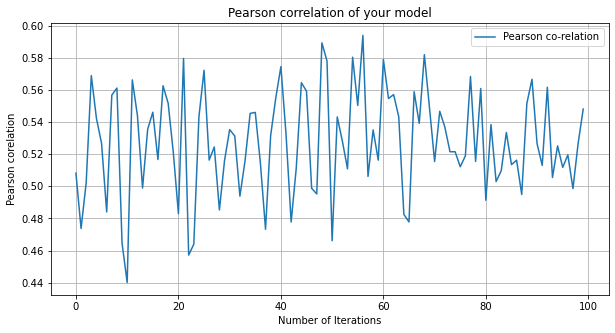

In [40]:
plotting.line_plot('Pearson correlation of your model', 
                   'Pearson co-relation', 
                   'Number of Iterations', 
                   'Pearson corelation',
                    range(len(al_pc100)),d
                    al_pc100)

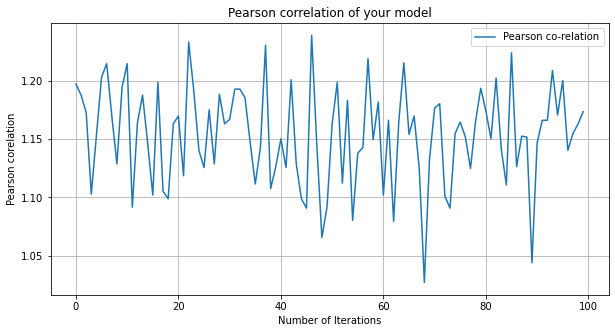

In [41]:
plotting.line_plot('Pearson correlation of your model', 
                   'Pearson co-relation', 
                   'Number of Iterations', 
                   'Pearson corelation',
                    range(len(al_rmse100)),
                    al_rmse100)

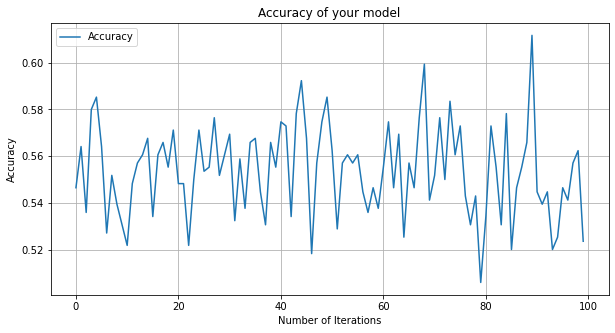

In [42]:
plotting.line_plot('Accuracy of your model', 
                   'Accuracy', 
                   'Number of Iterations', 
                   'Accuracy',
                   range(len(al_acc100)),
                   al_acc100)

In [43]:
sl_pc100, sl_rmse100, sl_acc100 = runmodel(features, label, RandomForestClassifier(),
                                            100, al=False)

After 0 iteration
Average pearson correlation is 0.5712621380735081
Average rmse is 1.1427159089231895
Average accuracy is 0.5360281195079086
After 10 iteration
Average pearson correlation is 0.5280882219124431
Average rmse is 1.152956829016908
Average accuracy is 0.5459338552484423
After 20 iteration
Average pearson correlation is 0.5307987300758997
Average rmse is 1.143408171964076
Average accuracy is 0.5526822328228305
After 30 iteration
Average pearson correlation is 0.5401441166052797
Average rmse is 1.1347806430866765
Average accuracy is 0.5569476727705653
After 40 iteration
Average pearson correlation is 0.5395372569064649
Average rmse is 1.1388448439548633
Average accuracy is 0.5548458999528483
After 50 iteration
Average pearson correlation is 0.5387503495414536
Average rmse is 1.138521518424535
Average accuracy is 0.5570143698955857
After 60 iteration
Average pearson correlation is 0.5359431950982905
Average rmse is 1.1411871798043356
Average accuracy is 0.5576651588925062
Aft

In [46]:
al_pc100r, al_rmse100r, al_acc100r = runmodel(features, label, RandomForestClassifier(300),
                                              100, al=True)

After 0 iteration
Average pearson correlation is 0.5671173475285414
Average rmse is 1.088363115256238
Average accuracy is 0.5746924428822495
After 10 iteration
Average pearson correlation is 0.5295509818522868
Average rmse is 1.1401149631715095
Average accuracy is 0.557597060233264
After 20 iteration
Average pearson correlation is 0.5372035526402675
Average rmse is 1.14437749774951
Average accuracy is 0.5556950372416102
After 30 iteration
Average pearson correlation is 0.5327686684191693
Average rmse is 1.1503269760955401
Average accuracy is 0.552072112931572
After 40 iteration
Average pearson correlation is 0.5279152686951346
Average rmse is 1.1570683452682617
Average accuracy is 0.5511166359466758
After 50 iteration
Average pearson correlation is 0.5298808350787757
Average rmse is 1.1544759083960348
Average accuracy is 0.5519142630690237
After 60 iteration
Average pearson correlation is 0.5316716312444435
Average rmse is 1.1515842597374644
Average accuracy is 0.5546976288570687
After

In [47]:
sl_pc100r, sl_rmse100r, sl_acc100r = runmodel(features, label, RandomForestClassifier(300),
                                              100, al=False)

After 0 iteration
Average pearson correlation is 0.5327654714424833
Average rmse is 1.1663109341333837
Average accuracy is 0.5553602811950791
After 10 iteration
Average pearson correlation is 0.5224288516317263
Average rmse is 1.1587446520606255
Average accuracy is 0.5567982105767695
After 20 iteration
Average pearson correlation is 0.5318160222283412
Average rmse is 1.145398569809743
Average accuracy is 0.561971713114068
After 30 iteration
Average pearson correlation is 0.5332054038353224
Average rmse is 1.1506947257320141
Average accuracy is 0.5564941323204263
After 40 iteration
Average pearson correlation is 0.5356129051033413
Average rmse is 1.150245469396553
Average accuracy is 0.5554031462985983
After 50 iteration
Average pearson correlation is 0.5348249519151033
Average rmse is 1.1515791746025679
Average accuracy is 0.5547055377511285
After 60 iteration
Average pearson correlation is 0.5337120360423547
Average rmse is 1.151487453478017
Average accuracy is 0.5549569275980295
Afte

In [44]:
al_pc100s, al_rmse100s, al_acc100s = runmodel(features, label, svm.SVC(),
                                              100, al=True)

After 0 iteration
Average pearson correlation is 0.017503806537020744
Average rmse is 1.584747156516734
Average accuracy is 0.44815465729349735


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


After 10 iteration
Average pearson correlation is nan
Average rmse is 1.5107375528197713
Average accuracy is 0.4793097938967886
After 20 iteration
Average pearson correlation is nan
Average rmse is 1.4786379762644213
Average accuracy is 0.4869863586911039
After 30 iteration
Average pearson correlation is nan
Average rmse is 1.4808382221670606
Average accuracy is 0.48795283179318555


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


After 40 iteration
Average pearson correlation is nan
Average rmse is 1.4914944664397407
Average accuracy is 0.4854472973552231
After 50 iteration
Average pearson correlation is nan
Average rmse is 1.4986186711795884
Average accuracy is 0.4815121127537131
After 60 iteration
Average pearson correlation is nan
Average rmse is 1.4989574525934999
Average accuracy is 0.48166181681984493
After 70 iteration
Average pearson correlation is nan
Average rmse is 1.500405356447874
Average accuracy is 0.48132379514344414
After 80 iteration
Average pearson correlation is nan
Average rmse is 1.495435513658146
Average accuracy is 0.4828700991559809


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


After 90 iteration
Average pearson correlation is nan
Average rmse is 1.494447338093424
Average accuracy is 0.48285984665598014


In [45]:
sl_pc100s, sl_rmse100s, sl_acc100s = runmodel(features, label, svm.SVC(),
                                              100, al=False)

After 0 iteration
Average pearson correlation is 0.4091512684889338
Average rmse is 1.4092339216913898
Average accuracy is 0.492091388400703
After 10 iteration
Average pearson correlation is 0.31331641651816
Average rmse is 1.4663288003169077
Average accuracy is 0.4831442722479629


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


After 20 iteration
Average pearson correlation is nan
Average rmse is 1.493148298613212
Average accuracy is 0.47962172566741995
After 30 iteration
Average pearson correlation is nan
Average rmse is 1.489781187155437
Average accuracy is 0.48041272180962646
After 40 iteration
Average pearson correlation is nan
Average rmse is 1.479877803421103
Average accuracy is 0.4831754468687042
After 50 iteration
Average pearson correlation is nan
Average rmse is 1.4894575686575375
Average accuracy is 0.4812364313036287
After 60 iteration
Average pearson correlation is nan
Average rmse is 1.4950160411820939
Average accuracy is 0.4812584632227952
After 70 iteration
Average pearson correlation is nan
Average rmse is 1.4882472964749602
Average accuracy is 0.4829822520359415


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


After 80 iteration
Average pearson correlation is nan
Average rmse is 1.4906637655832542
Average accuracy is 0.48282670485365276


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


After 90 iteration
Average pearson correlation is nan
Average rmse is 1.4918392234122255
Average accuracy is 0.4828791595048186


/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ganesh/anaconda3/envs/asag/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
